# Tarea 2 - Recuperación de Información Multimedia
El siguiente reporte pretende contestar las preguntas planteadas en el enunciado. Para esto se deben cargar los descriptores, y analizar los datos aplicando las técnicas vistas en clases.

## Carga de Descriptores

In [25]:
import numpy as np
import os


def load_file(filename, num_vectors, vector_dimensions):
    assert os.path.isfile(filename), "no existe archivo " + filename
    mat = np.fromfile(filename, dtype=np.float32)
    return np.reshape(mat, (num_vectors, vector_dimensions))


def load_dataset_pair(dirname, num_vectors_q, num_vectors_r, vector_dimensions):
    file_q = "{}/Q-{}_{}_4F.bin".format(dirname, num_vectors_q, vector_dimensions)
    file_r = "{}/R-{}_{}_4F.bin".format(dirname, num_vectors_r, vector_dimensions)
    data_q = load_file(file_q, num_vectors_q, vector_dimensions)
    data_r = load_file(file_r, num_vectors_r, vector_dimensions)
    return data_q, data_r


(dataset_q_mel, dataset_r_mel) = load_dataset_pair("descriptores/MEL128", 21573, 33545, 128)
print("Q={} R={}".format(dataset_q_mel.shape, dataset_r_mel.shape))

(dataset_q_sift, dataset_r_sift) = load_dataset_pair("descriptores/SIFT", 2886, 202088, 128)
print("Q={} R={}".format(dataset_q_sift.shape, dataset_r_sift.shape))

(dataset_q_vgg, dataset_r_vgg) = load_dataset_pair("descriptores/VGG19", 842, 10171, 4096)
print("Q={} R={}".format(dataset_q_vgg.shape, dataset_r_vgg.shape))

Q=(21573, 128) R=(33545, 128)
Q=(2886, 128) R=(202088, 128)
Q=(842, 4096) R=(10171, 4096)


## Construcción y Aplicación de Índices

In [26]:
import pyflann
import time

#crea un objeto flann
flann = pyflann.FLANN()

### Linear Scan

In [27]:
def aplicar_lscan(dataset_q, dataset_r):
    #construir el indice linear scan
    t0 = time.time()
    flann.build_index(dataset_r, algorithm="linear")
    t1 = time.time()
    print("construccion linear scan={:.1f}".format(t1-t0))

    #buscar el NN usando el ultimo indice construido (linear scan)
    t0 = time.time()
    lscan_results, lscan_dists = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
    t1 = time.time()
    tiempo_lscan = t1-t0
    print("busqueda linear scan={:.1f}".format(tiempo_lscan))
    return lscan_results, lscan_dists, tiempo_lscan

In [29]:
lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel = aplicar_lscan(dataset_q_mel, dataset_r_mel)

construccion linear scan=0.3
busqueda linear scan=164.4


### KD-Tree

In [30]:
def evaluar_resultado(results, dists, tiempo, lscan_results, lscan_dists, tiempo_lscan):
    correctas = 0
    incorrectas = 0
    iguales = 0
    for i in range(len(lscan_results)):
        #comparar las distancias
        if dists[i] == lscan_dists[i]: 
            correctas += 1
        elif dists[i] > lscan_dists[i]: 
            incorrectas += 1        
        else:
            assert False, "distancia erronea!"
        #comparar el NN
        if results[i] == lscan_results[i]: 
            iguales += 1
    efectividad = 100 * correctas / (correctas + incorrectas)
    eficiencia = 100 * tiempo / tiempo_lscan
    print("efectividad={:.1f}% eficiencia={:.1f}% correctas={} incorrectas={} mismo-NN={}".format(efectividad, eficiencia, correctas, incorrectas, iguales))
    return efectividad, eficiencia, correctas, incorrectas, iguales

In [34]:
def aplicar_kdtree(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, trees, checks):
    #construir el indice kdtree con trees = trees
    t0 = time.time()
    flann.build_index(dataset_r, algorithm="kdtree", trees=trees)
    t1 = time.time()
    print("construccion kdtree={:.1f}, trees={}".format(t1-t0, trees))

    #buscar aproximada del NN con el ultimo indice construido (kdtree)
    t0 = time.time()
    approx_results, approx_dists = flann.nn_index(dataset_q, num_neighbors=1, cores=1, checks=checks)
    t1 = time.time()
    tiempo = t1-t0
    print("busqueda aproximada kdtree={:.1f}, trees={}".format(tiempo, trees))

    efectividad, eficiencia, correctas, incorrectas, iguales = evaluar_resultado(approx_results, approx_dists, tiempo, lscan_results, lscan_dists, tiempo_lscan)
    return efectividad, eficiencia, correctas, incorrectas, iguales

In [35]:
efectividad, eficiencia, correctas, incorrectas, iguales = aplicar_kdtree(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 1, 100)

construccion kdtree=0.3, trees=1
busqueda aproximada kdtree=1.9, trees=1
efectividad=56.4% eficiencia=1.2% correctas=12170 incorrectas=9403 mismo-NN=12164


In [60]:
def distance(r, l):
    dists = []
    for x in r:
        for y in l:
            dist = np.linalg.norm(x-y)
            if dist != 0:
                dists.append(dist)
    return np.array(dists)

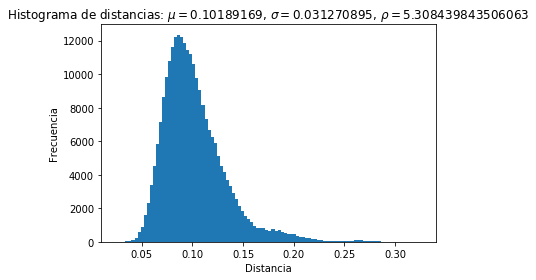

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

dataset_r = dataset_r_mel
dataset_r = dataset_r[np.random.choice(dataset_r.shape[0], 500, replace=False), :]

dists = distance(dataset_r, dataset_r)

mu, std = norm.fit(dists)
rho = (mu**2) / (2 * (std**2))

num_bins = 100

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(dists, num_bins)

ax.set_xlabel('Distancia')
ax.set_ylabel('Frecuencia')
ax.set_title(r'Histograma de distancias: $\mu=' + str(mu) + '$, $\sigma=' + str(std) + '$, $\\rho=' + str(rho) + '$')


plt.show()